In [1]:
import scipy
import numpy as np
from tools import *
from plots import *
set_seaborn()
%load_ext autoreload
%autoreload 2


In [2]:
downsample = 10
resPH, stimPH = read_lmc('PHOTO')
res3, stim3 = read_lmc('LMC-BG3')
res4, stim4 = read_lmc('LMC-BG4')
res5, stim5 = read_lmc('LMC-BG5')
res6, stim6 = read_lmc('LMC-BG6')


In [3]:
print(resPH.shape)

(105, 10000)


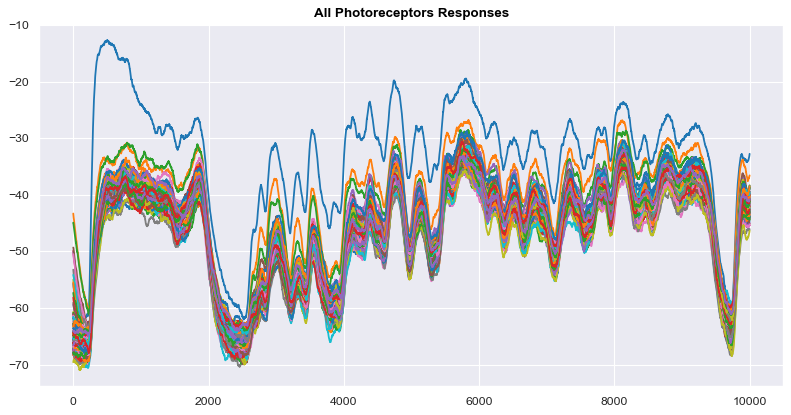

In [4]:
[plt.plot(x) for x in resPH]
plt.title('All Photoreceptors Responses')
plt.show()

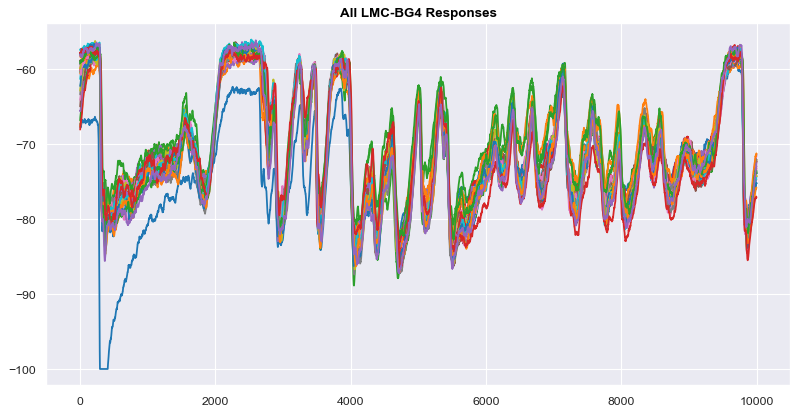

In [5]:
[plt.plot(x) for x in res4]
plt.title('All LMC-BG4 Responses')
plt.show()

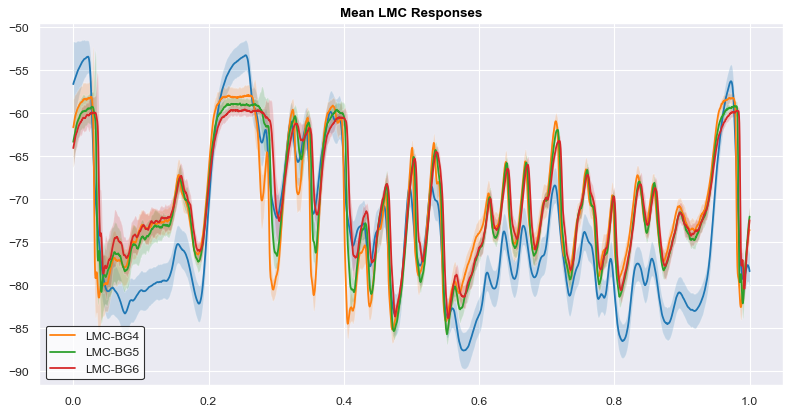

In [9]:
N = stimPH.shape[-1]
time = np.linspace(0,1,N)


plt_errors(time, np.mean(resPH*-1-120, axis=0),np.std(resPH*-1-120, axis=0))
# plt.title('Meam Photoreceptors Response')
# plt.show()

for i,r in enumerate([res4,res5,res6]):
    plt_errors(time, np.mean(r, axis=0), np.std(r, axis=0), label=f'LMC-BG{i+4}')

plt.title('Mean LMC Responses')
plt.legend()
plt.show()

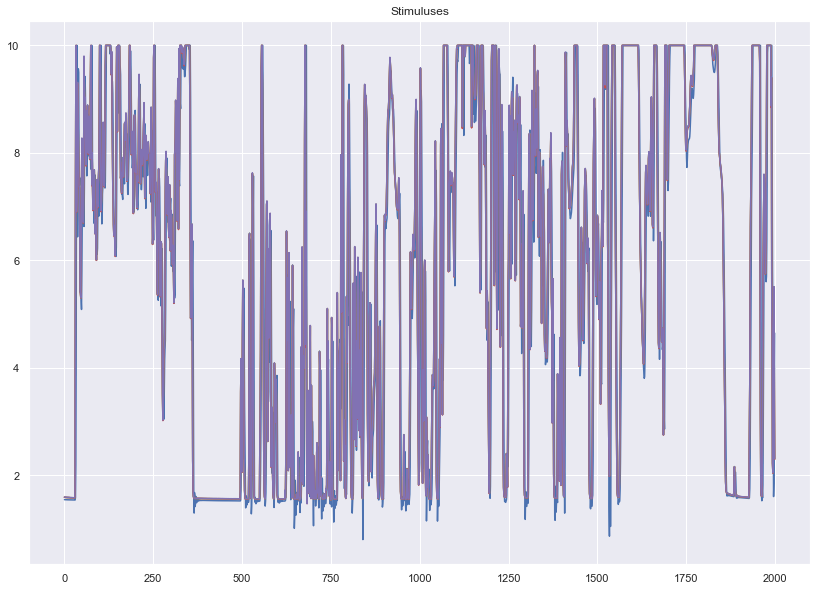

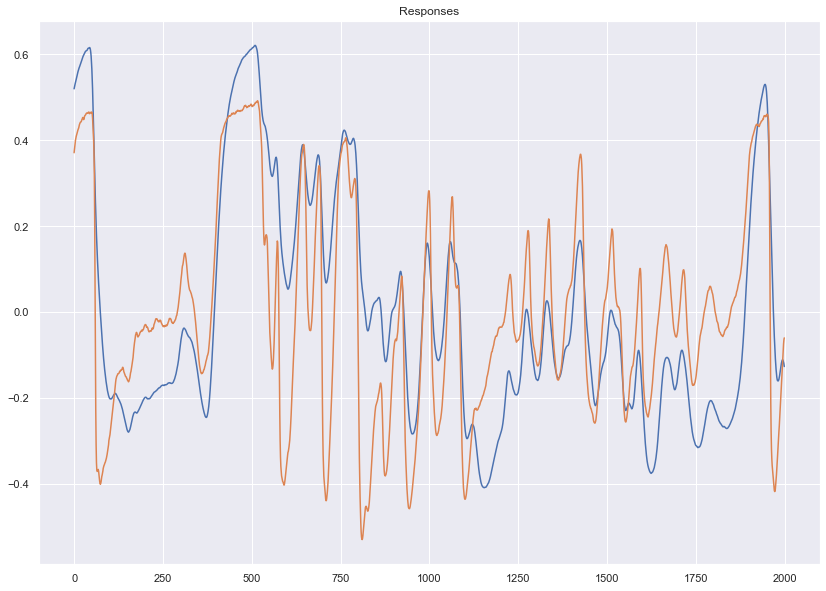

In [8]:
stims = [stimPH, stim3, stim4, stim5, stim6]
ress = [normalize(resPH *-1), normalize(res3)]

down = 5
for s in stims:
    x = np.mean(s[:, ::down], axis=0)
    plt.plot(x)
plt.title("Stimuluses"); plt.show();

down = 5
for r in ress:
    x = np.mean(r[:, ::down], axis=0)
    plt.plot(x)
plt.title("Responses"); plt.show();


In [98]:
# take sig down sample
down = 10
sig = resPH_norm[::down]

T = len(sig) # total time
r = T // 2 # length of lag vector
L = T-r-1  # number of lag vectors

X1, X2 = np.zeros((r,r)), np.zeros((r,r)) # init X1 = <x_t+1, x_t.T> and X2 = <x_t, x_t.T>
for i in range(L):
    xt = np.expand_dims(sig[i:i+r], axis=1)
    xt1 = np.expand_dims(sig[i+1:i+r+1], axis=1)
    X1 += (xt1 @ xt.T) / L # compute <x_t+1, x_t.T>, averaging over time
    X2 += (xt @ xt.T) / L  # compute <x_t, x_t.T>, averaging over time 
print(X1.shape, X2.shape)

A = X1 @ (np.linalg.inv(X2)) # compute A = <x_t+1, x_t.T> <x_t, x_t.T>^-1


(500, 500) (500, 500)


<ipython-input-99-f8b070ac2efb>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  y[i] = v @ sig[i:i+r]


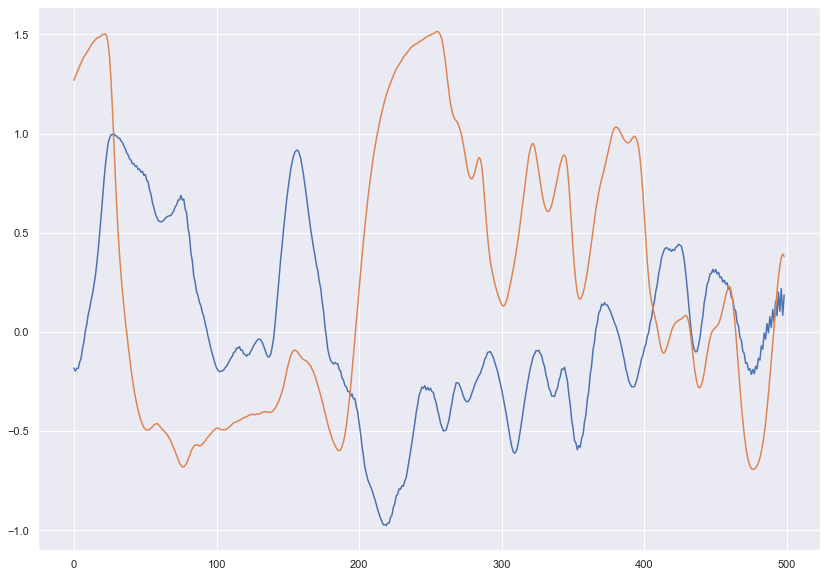

In [99]:
W, Vl, Vr = scipy.linalg.eig(A, left=True) # get left eigenvectors if A (Vl)
# project time serires onto top left eigenvector of A
y = np.zeros(L) # y is new time seriest
v = Vl[:,0].T # top left eigenvector of A
for i in range(L):
    y[i] = v @ sig[i:i+r]

# plot y and compare to neuron response  
plt.plot(normalize(y))
plt.plot(resPH_norm[::down][:L]*-1)
plt.show()

In [121]:
down = 2
sig = resPH_norm[::down]

T = len(sig) # total time
r = T // 10 # length of lag vector
L = T -r
H = build_hankel(sig, r)
A, U, V = HAVOK(H, 1, r, 1, center=True, return_uv=True)

<ipython-input-122-f8b070ac2efb>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  y[i] = v @ sig[i:i+r]


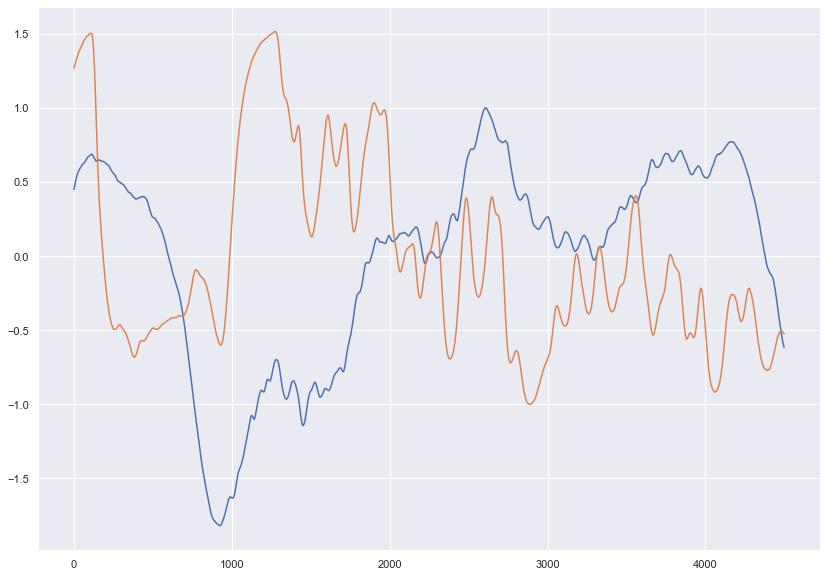

In [122]:
W, Vl, Vr = scipy.linalg.eig(A, left=True) # get left eigenvectors if A (Vl)
# project time serires onto top left eigenvector of A
y = np.zeros(L) # y is new time seriest
v = Vl[:,0].T # top left eigenvector of A
for i in range(L):
    y[i] = v @ sig[i:i+r]

# plot y and compare to neuron response  
plt.plot(normalize(y))
plt.plot(resPH_norm[::down][:L]*-1)
plt.show()

In [ ]:
def siavash(Xseries, N, shift):

    X = scipy.linalg.hankel(Xseries)[: N + shift, : -N - shift + 1]

    X0 = X[:-shift]
    Xp = X[shift:]

    print(X0.shape)

    X0Xp = X0 @ Xp.T / X0.shape[1]
    X0X0 = X0 @ X0.T / X0.shape[1]

    GEV_sol = scipy.linalg.eig(X0Xp, X0X0)

    evals = np.real_if_close(GEV_sol[0])
    evecs = np.real_if_close(GEV_sol[1])

    sort_order = np.argsort(evals)[::-1]
    eigvals = evals[sort_order]
    eigvecs = evecs[:, sort_order]

    return eigvecs, eigvals

    print(eigvals.shape, eigvecs.shape)
    plt.plot(eigvecs[0]); plt.show();



In [145]:
Xseries = np.arange(0,10,1)
N = 5
shift = 2
X = scipy.linalg.hankel(Xseries)[: N + shift, : -N - shift + 1]

X0 = X[:-shift]
Xp = X[shift:]

print(X0)
print(Xp)


[[0 1 2 3]
 [1 2 3 4]
 [2 3 4 5]
 [3 4 5 6]
 [4 5 6 7]]
[[2 3 4 5]
 [3 4 5 6]
 [4 5 6 7]
 [5 6 7 8]
 [6 7 8 9]]


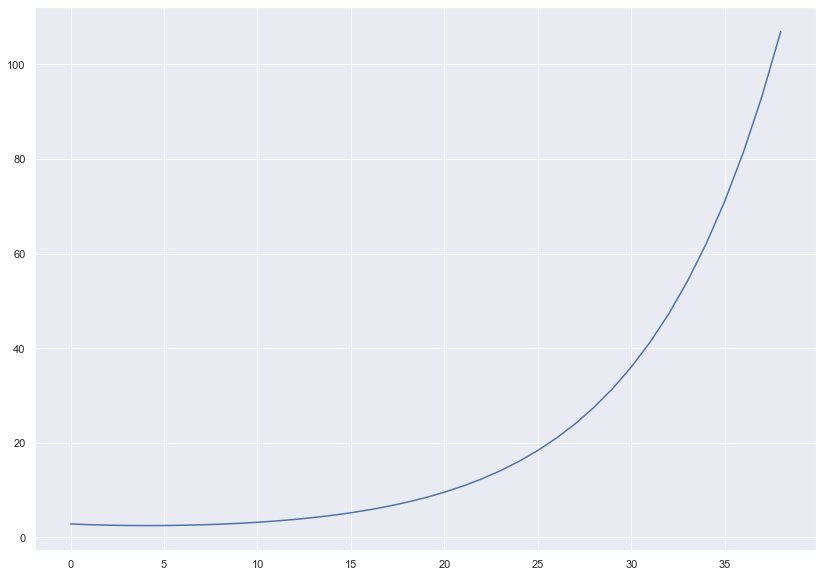

(7, 30)
(7,) (7, 7)


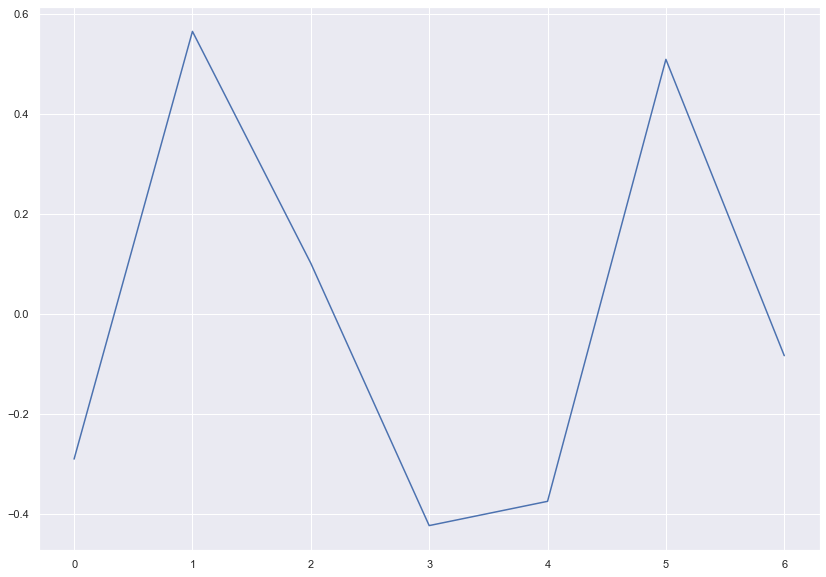

In [141]:
Xseries = np.exp(time.reshape(-1, 1) * Exps.reshape(1, -1)) @ Inits
plt.plot(Xseries); plt.show();

N = 7
shift = 3
X = scipy.linalg.hankel(Xseries)[: N + shift, : -N - shift + 1]

X0 = X[:-shift]
Xp = X[shift:]

print(X0.shape)

X0Xp = X0 @ Xp.T / X0.shape[1]
X0X0 = X0 @ X0.T / X0.shape[1]

GEV_sol = scipy.linalg.eig(X0Xp, X0X0)
le, la, ri = scipy.linalg.svd(scipy.linalg.inv(X0X0) @ X0Xp)

evals = np.real_if_close(GEV_sol[0])
evecs = np.real_if_close(GEV_sol[1])

sort_order = np.argsort(evals)[::-1]
eigvals = evals[sort_order]
eigvecs = evecs[:, sort_order]

print(eigvals.shape, eigvecs.shape)
plt.plot(eigvecs[:, 0]); plt.show();
# for i in range(len(ri)):
#     si = np.sign(ri[i, -1])
#     ri[i] = ri[i] * si
#     le[:, i] = le[:, i] * si

# datasvd[(N, noise)]["lefts"].append(le)
# datasvd[(N, noise)]["lambdas"].append(la)
# datasvd[(N, noise)]["rights"].append(ri)
